# PMEncoder vs IMEncoder 可視化

PMEncoder（位相変調）とIMEncoder（強度変調）の出力特性を2次元入力空間で比較します。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import os

# パスを追加
sys.path.append(os.path.abspath("../.."))
from models.IntegrationModel import PMEncoder, IMEncoder

# デバイス設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
# パラメータ設定
alpha = np.pi
input_dim = 2  # 2次元入力
output_dim = 1  # 1次元出力（可視化のため）
resolution = 300  # グリッド解像度

# エンコーダーの初期化
pm_encoder = PMEncoder(input_dim=input_dim, output_dim=output_dim, alpha=alpha, device=device, seed=42)
im_encoder = IMEncoder(input_dim=input_dim, output_dim=output_dim, alpha=alpha, device=device)

print(f"PMEncoder - alpha: {pm_encoder.alpha}")
print(f"PMEncoder - B shape: {pm_encoder.B.shape}")
print(f"IMEncoder - B shape: {im_encoder.B.shape}")

PMEncoder - alpha: tensor([2.4019, 2.6075], device='cuda:0')
PMEncoder - B shape: torch.Size([1, 2])
IMEncoder - B shape: torch.Size([1, 2])


In [3]:
# 2次元入力空間の作成
x1 = np.linspace(0, 1, resolution)  # PMEncoderは[0,1]を想定
x2 = np.linspace(0, 1, resolution)
X1, X2 = np.meshgrid(x1, x2)

# 入力データをテンソルに変換
input_grid = np.stack([X1.flatten(), X2.flatten()], axis=1)  # (resolution^2, 2)
input_tensor = torch.tensor(input_grid, dtype=torch.float32).to(device)

print(f"Input tensor shape: {input_tensor.shape}")
print(f"Input range: [{input_tensor.min():.3f}, {input_tensor.max():.3f}]")

Input tensor shape: torch.Size([90000, 2])
Input range: [0.000, 1.000]


In [4]:
# エンコーダーの出力を計算
with torch.no_grad():
    # PMEncoder（位相変調）
    pm_output = pm_encoder(input_tensor)
    I_PM = pm_output.cpu().numpy().reshape(resolution, resolution)
    
    # IMEncoder（強度変調）
    im_output = im_encoder(input_tensor)
    I_IM = im_output.cpu().numpy().reshape(resolution, resolution)

print(f"PM output range: [{I_PM.min():.3f}, {I_PM.max():.3f}]")
print(f"IM output range: [{I_IM.min():.3f}, {I_IM.max():.3f}]")

PM output range: [0.208, 0.793]
IM output range: [0.000, 0.226]


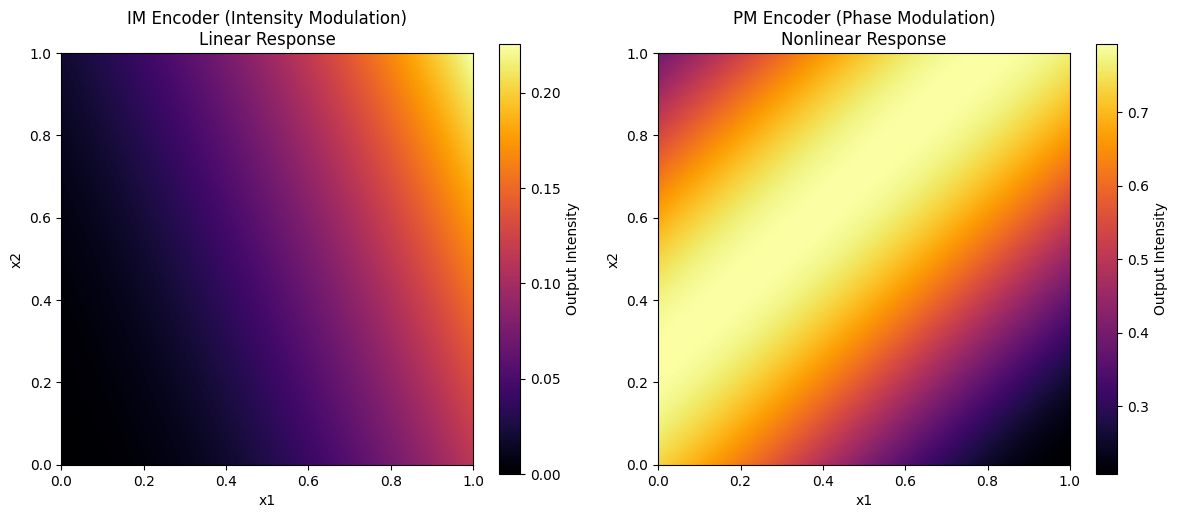

In [5]:
# 可視化
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# IMEncoder（線形的）
im1 = ax[0].imshow(I_IM, extent=[0, 1, 0, 1], origin='lower', cmap='inferno')
ax[0].set_title('IM Encoder (Intensity Modulation)\nLinear Response', fontsize=12)
ax[0].set_xlabel('x1')
ax[0].set_ylabel('x2')
plt.colorbar(im1, ax=ax[0], label='Output Intensity')

# PMEncoder（非線形）
im2 = ax[1].imshow(I_PM, extent=[0, 1, 0, 1], origin='lower', cmap='inferno')
ax[1].set_title('PM Encoder (Phase Modulation)\nNonlinear Response', fontsize=12)
ax[1].set_xlabel('x1')
ax[1].set_ylabel('x2')
plt.colorbar(im2, ax=ax[1], label='Output Intensity')

plt.tight_layout()
plt.show()

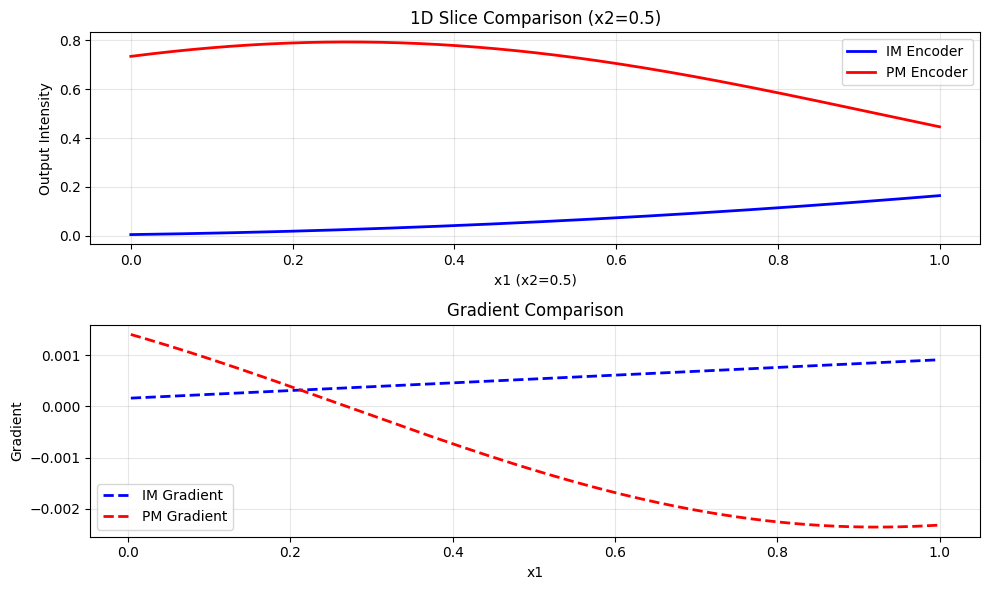

In [6]:
# 1次元スライスでの詳細比較
# x2=0.5での断面を取得
slice_idx = resolution // 2
x1_slice = x1
im_slice = I_IM[slice_idx, :]
pm_slice = I_PM[slice_idx, :]

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(x1_slice, im_slice, 'b-', linewidth=2, label='IM Encoder')
plt.plot(x1_slice, pm_slice, 'r-', linewidth=2, label='PM Encoder')
plt.xlabel('x1 (x2=0.5)')
plt.ylabel('Output Intensity')
plt.title('1D Slice Comparison (x2=0.5)')
plt.legend()
plt.grid(True, alpha=0.3)

# 勾配の比較
plt.subplot(2, 1, 2)
im_grad = np.gradient(im_slice)
pm_grad = np.gradient(pm_slice)
plt.plot(x1_slice[1:], im_grad[1:], 'b--', linewidth=2, label='IM Gradient')
plt.plot(x1_slice[1:], pm_grad[1:], 'r--', linewidth=2, label='PM Gradient')
plt.xlabel('x1')
plt.ylabel('Gradient')
plt.title('Gradient Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# 統計情報の比較
print("=== エンコーダー出力の統計情報 ===")
print(f"IM Encoder:")
print(f"  平均: {I_IM.mean():.4f}")
print(f"  標準偏差: {I_IM.std():.4f}")
print(f"  最小値: {I_IM.min():.4f}")
print(f"  最大値: {I_IM.max():.4f}")
print(f"  ダイナミックレンジ: {I_IM.max() - I_IM.min():.4f}")

print(f"\nPM Encoder:")
print(f"  平均: {I_PM.mean():.4f}")
print(f"  標準偏差: {I_PM.std():.4f}")
print(f"  最小値: {I_PM.min():.4f}")
print(f"  最大値: {I_PM.max():.4f}")
print(f"  ダイナミックレンジ: {I_PM.max() - I_PM.min():.4f}")

# 線形性の測定（相関係数）
x_sum = X1 + X2  # 入力の線形結合
im_corr = np.corrcoef(x_sum.flatten(), I_IM.flatten())[0, 1]
pm_corr = np.corrcoef(x_sum.flatten(), I_PM.flatten())[0, 1]

print(f"\n=== 線形性の測定（入力和との相関） ===")
print(f"IM Encoder 相関係数: {im_corr:.4f}")
print(f"PM Encoder 相関係数: {pm_corr:.4f}")

=== エンコーダー出力の統計情報 ===
IM Encoder:
  平均: 0.0675
  標準偏差: 0.0513
  最小値: 0.0000
  最大値: 0.2257
  ダイナミックレンジ: 0.2257

PM Encoder:
  平均: 0.6420
  標準偏差: 0.1541
  最小値: 0.2079
  最大値: 0.7929
  ダイナミックレンジ: 0.5850

=== 線形性の測定（入力和との相関） ===
IM Encoder 相関係数: 0.9008
PM Encoder 相関係数: 0.0345


In [8]:
# 高次元出力での比較（output_dim=4）
print("=== 高次元出力での比較 ===")
output_dim_multi = 4

pm_encoder_multi = PMEncoder(input_dim=2, output_dim=output_dim_multi, alpha=alpha, device=device, seed=42)
im_encoder_multi = IMEncoder(input_dim=2, output_dim=output_dim_multi, alpha=alpha, device=device)

# サンプル入力での出力確認
sample_input = torch.tensor([[0.0, 0.0], [0.5, 0.5], [1.0, 1.0]], dtype=torch.float32).to(device)

with torch.no_grad():
    pm_multi_out = pm_encoder_multi(sample_input)
    im_multi_out = im_encoder_multi(sample_input)

print(f"サンプル入力: {sample_input.cpu().numpy()}")
print(f"PM Encoder 出力 (4次元):")
print(pm_multi_out.cpu().numpy())
print(f"IM Encoder 出力 (4次元):")
print(im_multi_out.cpu().numpy())

# 出力の多様性（各次元の分散）
pm_var = pm_multi_out.var(dim=0).cpu().numpy()
im_var = im_multi_out.var(dim=0).cpu().numpy()

print(f"\n各次元の分散:")
print(f"PM Encoder: {pm_var}")
print(f"IM Encoder: {im_var}")

=== 高次元出力での比較 ===
サンプル入力: [[0.  0. ]
 [0.5 0.5]
 [1.  1. ]]
PM Encoder 出力 (4次元):
[[0.73092014 0.26907986]
 [0.7482037  0.25179642]
 [0.7628645  0.23713557]]
IM Encoder 出力 (4次元):
[[0.         0.         0.         0.        ]
 [0.0564189  0.30132297 0.5532314  0.00478928]
 [0.2256756  1.2052919  2.2129257  0.01915714]]

各次元の分散:
PM Encoder: [0.00025568 0.00025568]
IM Encoder: [1.3793400e-02 3.9344731e-01 1.3262817e+00 9.9394747e-05]
